<a href="https://colab.research.google.com/github/Taweilo/AB-test/blob/main/Code_A_B_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MIT License

Copyright (c) 2023 Tawei Lo

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# A/B test

 <img src="https://www.convertize.com/wp-content/uploads/2021/01/what-is-split-ab-testing-hero.jpg" width="1100" height="450">

## 1. Business Understanding
Via the Hypothesis testing, we can evaluate which feature has a better performance.

### Importing all the libraries

In [45]:
# Data wrangling
import pandas as pd # handle dataframe &
import numpy as np # deal with number and data
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Statatical testing
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

import warnings
warnings.filterwarnings('ignore')

## 2. Data Understanding

### 2.1 Loading the data
A/B Test Aggregated Data: https://www.kaggle.com/datasets/sergylog/ab-test-aggregated-data

In [46]:
# Provide the raw file URL
csv_url = 'https://raw.githubusercontent.com/Taweilo/AB-test/main/ab_test_results_aggregated_views_clicks_2.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(csv_url)
# Display the first few rows of the DataFrame
df.head()

,user_id,group,views,clicks
0,1,control,10.0,0.0
1,2,control,1.0,0.0
2,3,control,1.0,0.0
3,4,control,2.0,0.0
4,5,control,3.0,0.0


### 2.2 Feature Description

| Name | Measurement Level| Description |
| ----  | ---------------- | ---------- |
| **user_id**  | int | user unique id |
| **group**  | obj | experiment group |
| **views** | int | number of webpage views |
| **clicks** | int | number of experimental feature clicks |

In [47]:
#check dimension
df.shape

(120000, 4)

In [48]:
# check data type and missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  120000 non-null  int64  
 1   group    120000 non-null  object 
 2   views    120000 non-null  float64
 3   clicks   120000 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


In [49]:
# how many data are missing of each variable
null_counts = df.isnull().sum()
null_counts

user_id    0
group      0
views      0
clicks     0
dtype: int64

In [50]:
# check the unique value of categorical variable: Influencer
# if data are not standardized, need to be improved
unique_values = df['group'].unique()
print(unique_values)

['control' 'test']


In [51]:
group_counts = df['group'].value_counts()
print(group_counts)

control    60000
test       60000
Name: group, dtype: int64


In [52]:
# Descriptive analysis
df.describe().round(1)

,user_id,views,clicks
count,120000.0,120000.0,120000.0
mean,60000.5,5.0,0.2
std,34641.2,5.9,0.5
min,1.0,1.0,0.0
25%,30000.8,2.0,0.0
50%,60000.5,3.0,0.0
75%,90000.2,6.0,0.0
max,120000.0,205.0,9.0


In [53]:
corr = df.corr()
corr

,user_id,views,clicks
user_id,1.000000,0.005392,0.020422
views,0.005392,1.000000,0.447891
clicks,0.020422,0.447891,1.000000


## 3. Data Preparation


### 3.1 Check mising data

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  120000 non-null  int64  
 1   group    120000 non-null  object 
 2   views    120000 non-null  float64
 3   clicks   120000 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


### 3.2 create extra col & calculate CTR

In [55]:
df.head()

,user_id,group,views,clicks
0,1,control,10.0,0.0
1,2,control,1.0,0.0
2,3,control,1.0,0.0
3,4,control,2.0,0.0
4,5,control,3.0,0.0


In [56]:
# Assuming 'clicks' and 'impressions' columns exist in your DataFrame 'df'
df['CTR%'] = (df['clicks'] / df['views'])*100

# Displaying the DataFrame with the new 'CTR' column
df.head()

,user_id,group,views,clicks,CTR%
0,1,control,10.0,0.0,0.0
1,2,control,1.0,0.0,0.0
2,3,control,1.0,0.0,0.0
3,4,control,2.0,0.0,0.0
4,5,control,3.0,0.0,0.0


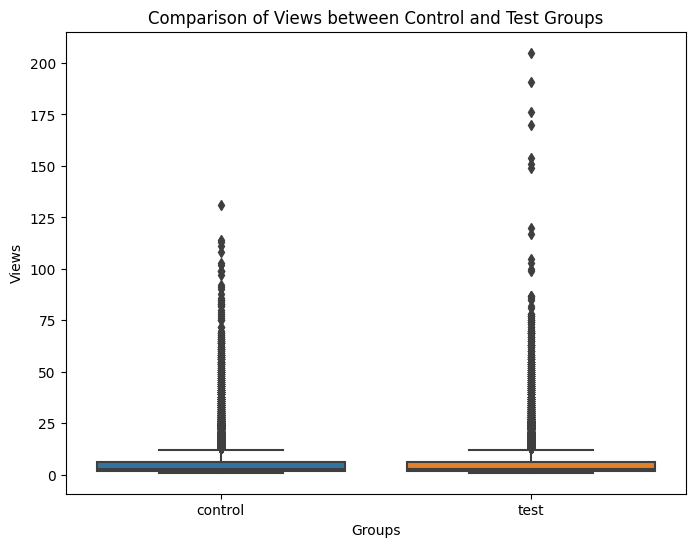

Average Views:
group
control    4.95240
test       5.02975
Name: views, dtype: float64


In [57]:
# boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='group', y='views', data=df)
plt.title('Comparison of Views between Control and Test Groups')
plt.xlabel('Groups')
plt.ylabel('Views')
plt.show()

# Calculating average views for each group
average_views = df.groupby('group')['views'].mean()
print("Average Views:")
print(average_views)

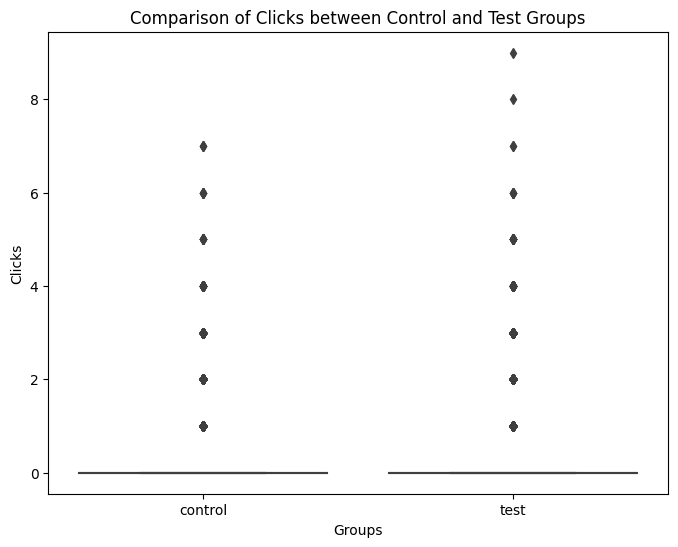

Average Clicks:
group
control    0.171717
test       0.193667
Name: clicks, dtype: float64


In [58]:
# boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='group', y='clicks', data=df)
plt.title('Comparison of Clicks between Control and Test Groups')
plt.xlabel('Groups')
plt.ylabel('Clicks')
plt.show()
plt.show()

# Calculating average clicks for each group
average_clicks = df.groupby('group')['clicks'].mean()
print("Average Clicks:")
print(average_clicks)

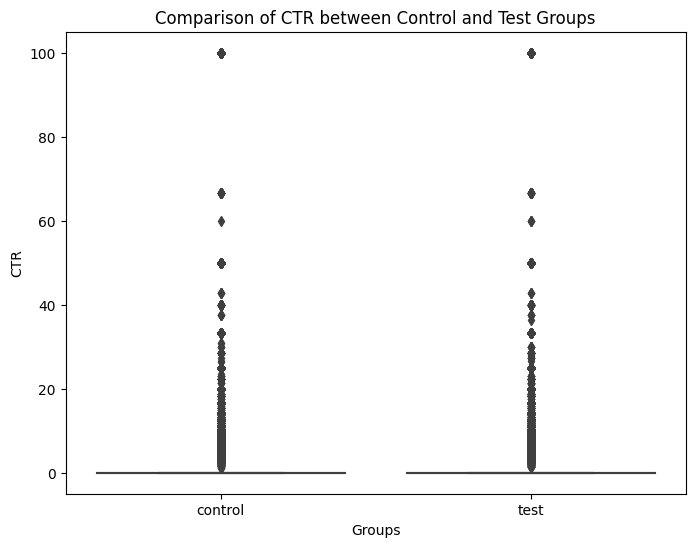

Average CTR (%):
group
control    3.465443
test       3.864758
Name: CTR%, dtype: float64


In [59]:
# boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='group', y='CTR%', data=df)
plt.title('Comparison of CTR between Control and Test Groups')
plt.xlabel('Groups')
plt.ylabel('CTR')
plt.show()
plt.show()

# Calculating average clicks for each group
average_CTR = df.groupby('group')['CTR%'].mean()
print("Average CTR (%):")
print(average_CTR)

## 4. Statistical testing
### 4.1 test views

In [60]:
# Assuming 'df' is your DataFrame
control_data = df[df['group'] == 'control']['views']
test_data = df[df['group'] == 'test']['views']

# Perform Shapiro-Wilk test for the control group
statistic_control, p_value_control = shapiro(control_data)
print(f"Control Group - Shapiro-Wilk Test Statistic: {statistic_control}")
print(f"Control Group - P-value: {p_value_control}")

# Perform Shapiro-Wilk test for the test group
statistic_test, p_value_test = shapiro(test_data)
print(f"Test Group - Shapiro-Wilk Test Statistic: {statistic_test}")
print(f"Test Group - P-value: {p_value_test}")



Control Group - Shapiro-Wilk Test Statistic: 0.591523289680481
Control Group - P-value: 0.0
Test Group - Shapiro-Wilk Test Statistic: 0.566509485244751
Test Group - P-value: 0.0


In [61]:
mannwhitneyu(df.loc[(df.group == 'test'), 'views'],
             df.loc[(df.group == 'control'), 'views'])

MannwhitneyuResult(statistic=1813837434.5, pvalue=0.019769045140100635)

### 4.2 test clicks

In [62]:
# Assuming 'df' is your DataFrame
control_data = df[df['group'] == 'control']['clicks']
test_data = df[df['group'] == 'test']['clicks']

# Perform Shapiro-Wilk test for the control group
statistic_control, p_value_control = shapiro(control_data)
print(f"Control Group - Shapiro-Wilk Test Statistic: {statistic_control}")
print(f"Control Group - P-value: {p_value_control}")

# Perform Shapiro-Wilk test for the test group
statistic_test, p_value_test = shapiro(test_data)
print(f"Test Group - Shapiro-Wilk Test Statistic: {statistic_test}")
print(f"Test Group - P-value: {p_value_test}")

Control Group - Shapiro-Wilk Test Statistic: 0.41856634616851807
Control Group - P-value: 0.0
Test Group - Shapiro-Wilk Test Statistic: 0.43864309787750244
Test Group - P-value: 0.0


In [63]:
mannwhitneyu(df.loc[(df.group == 'test'), 'clicks'],
             df.loc[(df.group == 'control'), 'clicks'])

MannwhitneyuResult(statistic=1827378002.0, pvalue=3.362997071095112e-13)

### 4.3 test CTR

When we look directly at the convertion rates, we see that there is a difference between the two groups. It seems that the new feature applied to the test group is getting more clicks. But this result can be misleading.

Therefore, we should seek an answer to the question of whether there is a statistically significant difference. Now we will run A/B testing.

For A/B testing to be applied, the data set must satisfy the Normality and Variance homogeneity assumptions. Then, it can be passed to the implementation of the hypothesis tests.

1. If normality and variance homogeneity is provided, an independent two-sample t-test (parametric test) is applied.
2. If normality and homogeneity of variance are not provided, the Mann-Whitney U test (non-parametric test) is performed. How to check the assumption of normality? In this, we will first determine the H0 and H1 hypotheses.
- H0 : The assumption of normality is provided.
- H1 : The assumption of normality is not provided.
Now let's check the assumption of normality.

In [64]:
# Assuming 'df' is your DataFrame
control_data = df[df['group'] == 'control']['CTR%']
test_data = df[df['group'] == 'test']['CTR%']

# Perform Shapiro-Wilk test for the control group
statistic_control, p_value_control = shapiro(control_data)
print(f"Control Group - Shapiro-Wilk Test Statistic: {statistic_control}")
print(f"Control Group - P-value: {p_value_control}")

# Perform Shapiro-Wilk test for the test group
statistic_test, p_value_test = shapiro(test_data)
print(f"Test Group - Shapiro-Wilk Test Statistic: {statistic_test}")
print(f"Test Group - P-value: {p_value_test}")

Control Group - Shapiro-Wilk Test Statistic: 0.34146255254745483
Control Group - P-value: 0.0
Test Group - Shapiro-Wilk Test Statistic: 0.363766610622406
Test Group - P-value: 0.0


Therefore, we will use the Mann-Whitney U test.

- H0 : There is no significant difference between the two groups in terms of click rate to the desired page.
- H1 : There is a difference.

In [65]:
CTR_control = df[df['group'] == 'control']['CTR%']
CTR_test = df[df['group'] == 'test']['CTR%']

# Performing the Mann-Whitney U test
statistic, p_value = mannwhitneyu(CTR_control, CTR_test)

# Printing the results
print(f"Mann-Whitney U Statistic: {statistic}")
print(f"P-value: {p_value}")
# Calculating average clicks for each group
average_CTR = df.groupby('group')['CTR%'].mean()
print("Average CTR (%):")
print(average_CTR)

Mann-Whitney U Statistic: 1773003355.0
P-value: 8.258019361570171e-13
Average CTR (%):
group
control    3.465443
test       3.864758
Name: CTR%, dtype: float64
